# pyMC sandbox

Follow the tutorial from: https://pymc-devs.github.io/pymc/tutorial.html

In [20]:
%matplotlib inline
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [50]:
disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
disasters_count = len(disasters_array)    

<Container object of 111 artists>

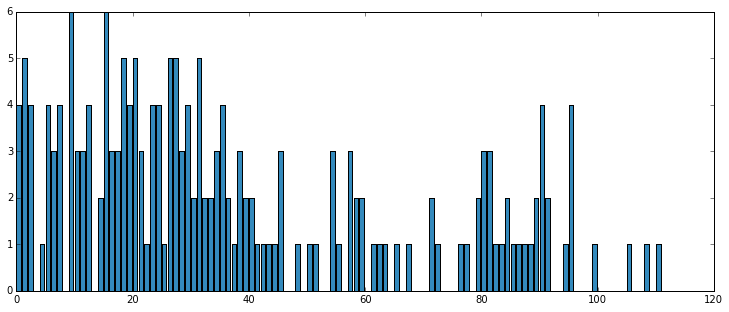

In [48]:
figsize(12.5, 5)
plt.bar(np.arange(disasters_count), disasters_array, color="#348ABD")

In [51]:
alpha = 1.0 / disasters_array.mean()
early_mean = pm.Exponential('early_mean', beta=alpha)
late_mean = pm.Exponential('late_mean', beta=alpha)

switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=disasters_count, doc='Switchpoint[year]')

In [52]:
@pm.deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(disasters_count)
    out[:s] = e
    out[s:] = l
    return out

In [53]:
disasters = pm.Poisson('disasters', mu=rate, value=disasters_array, observed=True)

In [54]:
model = pm.Model([disasters, early_mean, late_mean, switchpoint])

In [55]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.2 sec

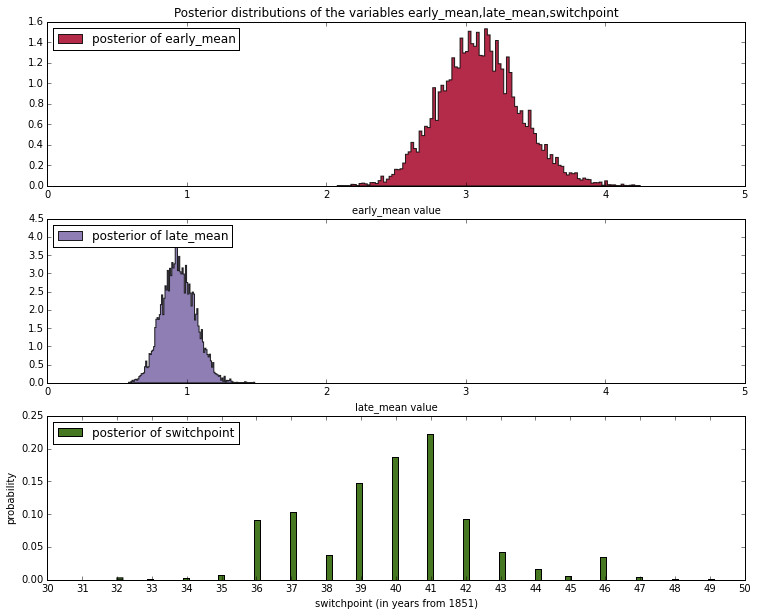

In [56]:
early_samples = mcmc.trace('early_mean')[:]
late_samples = mcmc.trace('late_mean')[:]
sp_samples = mcmc.trace('switchpoint')[:]

figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
# ax.set_autoscaley_on(False)

plt.hist(early_samples, histtype='stepfilled', bins=disasters_count, alpha=0.85,
         label="posterior of early_mean", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables early_mean,late_mean,switchpoint""")
plt.xlim([0, 5])
plt.xlabel("early_mean value")

ax = plt.subplot(312)
# ax.set_autoscaley_on(False)
plt.hist(late_samples, histtype='stepfilled', bins=disasters_count, alpha=0.85,
         label="posterior of late_mean", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 5])
plt.xlabel("late_mean value")

plt.subplot(313)
w = 1.0 / sp_samples.shape[0] * np.ones_like(sp_samples)
plt.hist(sp_samples, bins=disasters_count, alpha=1,
         label="posterior of switchpoint",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(disasters_count))

plt.legend(loc="upper left")
plt.xlim([30, 50])
plt.xlabel(r"switchpoint (in years from 1851)")
plt.ylabel("probability");

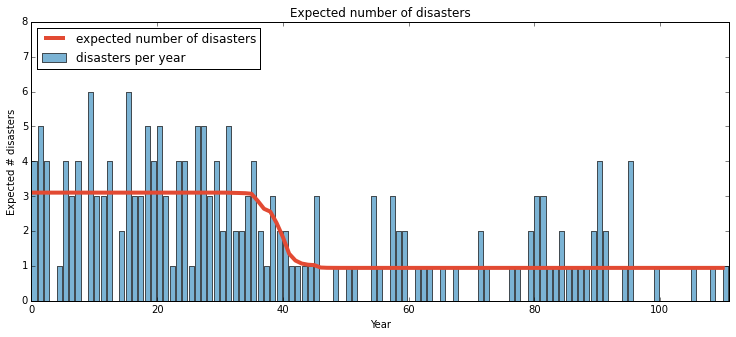

In [59]:
figsize(12.5, 5)
# N samples from the corresponding posterior distribution
N = sp_samples.shape[0]
expected_disasters_per_year = np.zeros(disasters_count)
for year in range(0, disasters_count):
    ix = year < sp_samples
    expected_disasters_per_year[year] = (early_samples[ix].sum()
                                       + late_samples[~ix].sum()) / N

plt.plot(range(disasters_count), expected_disasters_per_year, lw=4, color="#E24A33",
         label="expected number of disasters")
plt.xlim(0, disasters_count)
plt.xlabel("Year")
plt.ylabel("Expected # disasters")
plt.title("Expected number of disasters")
plt.ylim(0, 8)
plt.bar(np.arange(disasters_count),disasters_array, color="#348ABD", alpha=0.65,
        label="disasters per year")

plt.legend(loc="upper left");

In [62]:
print("Before: %f, after: %f" % (early_samples.mean(), late_samples.mean()))

Before: 3.101498, after: 0.943682


In [65]:
(early_samples/late_samples).mean()

3.3376336699114519